## **Catégorisez automatiquement des questions**

### partie 3/8 : Prédiction de tags, approche non-supervisée

#### <br> Proposition de mots clés, de type LDA avec visualisation en 2D des topics

<br>


## 1 Imports


### 1.1 Librairies


In [1]:
# ! qq imports inutiles, nettoyer

# general
import os, sys, random
import ast
import numpy as np
import pandas as pd
from pandarallel import pandarallel
from pprint import pprint

# Visualisation
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image

# NLP
from bs4 import BeautifulSoup
import re, string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# LDA
from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus
from gensim.models import LdaModel, CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim import similarities
from gensim.models.ldamulticore import LdaMulticore

# from sklearn.model_selection import GridSearchCV

# NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer


print('\nPython version ' + sys.version)
print('pyLDAvis version ' + pyLDAvis.__version__)

# Modify if necessary
num_cores = os.cpu_count()
print(f"\nNumber of CPU cores: {num_cores}")
pandarallel.initialize(progress_bar=False, nb_workers=6)


[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!



Python version 3.11.5 (main, Sep 11 2023, 13:23:44) [GCC 11.2.0]
pyLDAvis version 3.4.0

Number of CPU cores: 8
INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### 1.2 Fonctions


In [2]:
def get_missing_values(df):
    """Generates a DataFrame containing the count and proportion of missing values for each feature.

    Args:
        df (pandas.DataFrame): The input DataFrame to analyze.

    Returns:
        pandas.DataFrame: A DataFrame with columns for the feature name, count of missing values,
        count of non-missing values, proportion of missing values, and data type for each feature.
    """
    # Count the missing values for each column
    missing = df.isna().sum()

    # Calculate the percentage of missing values
    percent_missing = df.isna().mean() * 100

    # Create a DataFrame to store the results
    missings_df = pd.DataFrame({
        'column_name': df.columns,
        'missing': missing,
        'present': df.shape[0] - missing,  # Count of non-missing values
        'percent_missing': percent_missing.round(2),  # Rounded to 2 decimal places
        'type': df.dtypes
    })

    # Sort the DataFrame by the count of missing values
    missings_df.sort_values('missing', inplace=True)

    return missings_df

# with pd.option_context('display.max_rows', 1000):
#   display(get_missing_values(df))


def quick_look(df, miss=True):
    """
    Display a quick overview of a DataFrame, including shape, head, tail, unique values, and duplicates.

    Args:
        df (pandas.DataFrame): The input DataFrame to inspect.
        check_missing (bool, optional): Whether to check and display missing values (default is True).

    The function provides a summary of the DataFrame, including its shape, the first and last rows, the count of unique values per column, and the number of duplicates.
    If `check_missing` is set to True, it also displays missing value information.
    """
    print(f'shape : {df.shape}')

    display(df.head())
    display(df.tail())

    print('uniques :')
    display(df.nunique())

    print('Doublons ? ', df.duplicated(keep='first').sum(), '\n')

    if miss:
        display(get_missing_values(df))


def show_cloud(word_list):
    """
    Display a word cloud based on the provided list of words.

    Parameters:
    - word_list (list): A list of words to visualize in the word cloud.

    Returns:
    None
    """
    cloud = WordCloud(background_color='white',
                    stopwords=[],
                    max_words=50).generate(" ".join(word_list))
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()


### 1.3 Data


In [3]:
data = pd.read_csv('./../0_data/cleaned_data/bow_classic.csv', sep=',')

quick_look(data)


shape : (47665, 8)


,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy
0,2023-10-02 11:07:45,ImportError: cannot import name 'url_decode' f...,I am building a webapp using Flask. I imported...,"['python', 'flask', 'importerror', 'flask-logi...","['importerror', 'import', 'name', 'url']","['importerror', 'import', 'name', 'build', 'we...","['importerror', 'import']","['build', 'webapp', 'import', 'flask', 'login'..."
1,2023-09-25 09:05:11,Compilation error after upgrading to JDK 21 - ...,"After upgrading to JDK 21, I have the followin...","['spring-boot', 'compiler-errors', 'upgrade', ...","['compilation', 'error', 'upgrade', 'jdk', 'me...","['compilation', 'error', 'upgrade', 'jdk', 'me...","['compilation', 'error', 'upgrade', 'member', ...","['upgrade', 'follow', 'compilation', 'error', ..."
2,2023-08-28 07:22:32,Differences between Langchain & LlamaIndex,I'm currently working on developing a chatbot ...,"['chatbot', 'openai-api', 'langchain', 'large-...",['difference'],"['difference', 'work', 'develop', 'power', 'la...",['difference'],"['work', 'develop', 'power', 'want', 'provide'..."
3,2023-08-15 22:21:03,session not created: This version of ChromeDri...,I am running a Docker image from a Docker cont...,"['python', 'amazon-web-services', 'docker', 'g...","['session', 'create', 'version', 'chromedriver...","['session', 'create', 'version', 'chromedriver...","['session', 'create', 'version', 'support', 'v...","['run', 'image', 'container', 'environment', '..."
4,2023-08-01 08:16:21,Spring security method cannot decide pattern i...,When I try to run an application it fails to s...,"['java', 'spring-boot', 'eclipse', 'spring-sec...","['spring', 'security', 'method', 'decide', 'pa...","['spring', 'security', 'method', 'decide', 'pa...","['spring', 'security', 'method', 'decide', 'pa...","['try', 'run', 'application', 'fail', 'start',..."


,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy
47660,2011-05-23 22:22:56,How can I send a file document to the printer ...,Here's the basic premise:\nMy user clicks some...,"['c#', 'winforms', 'pdf', '.net-4.0', 'printing']","['send', 'file', 'document', 'printer', 'print']","['send', 'file', 'document', 'printer', 'print...","['send', 'file', 'document', 'printer', 'print']","['premise', 'user', 'click', 'file', 'spit', '..."
47661,2011-05-23 21:15:51,CA1014 Mark 'some.dll' with CLSCompliant(true)...,"When I run StyleCop, I got this error message ...","['visual-studio', 'visual-studio-2010', 'dll',...","['mark', 'dll', 'error', 'message', 'vs2010']","['mark', 'dll', 'error', 'message', 'vs2010', ...","['error', 'message']","['run', 'error', 'message', 'need', 'mark', 'd..."
47662,2011-05-23 21:05:59,How to change a text file's name in C++?,"I would like to change a txt file's name, but ...","['c++', 'algorithm', 'file', 'directory', 'fil...","['change', 'text', 'file', 'name', 'c']","['change', 'text', 'file', 'name', 'c', 'like'...","['change', 'text', 'file']","['like', 'change', 'txt', 'file', 'find', 'exa..."
47663,2011-05-23 20:06:35,php implode (101) with quotes,Imploding a simple array \nwould look like th...,"['php', 'arrays', 'string', 'csv', 'implode']","['php', 'quote']","['php', 'quote', 'array', 'look', 'array', 'ar...",['quote'],"['implode', 'array', 'look', 'array', 'email',..."
47664,2011-05-23 20:00:57,What characters are allowed in a iOS file name?,I'm looking for a way to make sure a string ca...,"['ios', 'file', 'filenames', 'character-encodi...","['character', 'allow', 'file', 'name']","['character', 'allow', 'file', 'name', 'look',...","['character', 'allow', 'file']","['look', 'way', 'string', 'file', 'section', '..."


uniques :


CreationDate    47659
title           47664
body            47665
all_tags        46017
title_nltk      47077
body_nltk       47665
title_spacy     41692
body_spacy      47659
dtype: int64

Doublons ?  0 



,column_name,missing,present,percent_missing,type
CreationDate,CreationDate,0,47665,0.0,object
title,title,0,47665,0.0,object
body,body,0,47665,0.0,object
all_tags,all_tags,0,47665,0.0,object
title_nltk,title_nltk,0,47665,0.0,object
body_nltk,body_nltk,0,47665,0.0,object
title_spacy,title_spacy,0,47665,0.0,object
body_spacy,body_spacy,0,47665,0.0,object


In [4]:
# Tt semble OK, sauf les types : le fait d'exporter nos données a converti nos listes de tokens en str

def turn_str_back_into_list(df):
    """Correct the type change due to .csv export"""

    df['title_nltk'] = df['title_nltk'].apply(ast.literal_eval)
    df['body_nltk'] = df['body_nltk'].apply(ast.literal_eval)
    df['title_spacy'] = df['title_spacy'].apply(ast.literal_eval)
    df['body_spacy'] = df['body_spacy'].apply(ast.literal_eval)


turn_str_back_into_list(data)


In [5]:
# Vérif
data[['title_nltk', 'body_nltk', 'title_spacy', 'body_spacy']].map(len).describe()

# OK, pas de liste vide (min = 1)


,title_nltk,body_nltk,title_spacy,body_spacy
count,47665.000000,47665.000000,47665.000000,47665.000000
mean,4.702927,88.608791,3.429288,50.777720
std,1.879631,116.791253,1.722844,58.312154
min,1.000000,3.000000,1.000000,1.000000
25%,3.000000,34.000000,2.000000,21.000000
50%,4.000000,57.000000,3.000000,36.000000
75%,6.000000,100.000000,4.000000,61.000000
max,21.000000,3095.000000,14.000000,2598.000000


In [6]:
# Utile si nos inputs st sous forme de string
# mais il semble qu'on va plutôt conserver la liste de tokens au final

def fix_false_null_values(df):
    """
    Replace NaN values in specified columns with the string 'null'.
    ! USE ONLY AFTER VERIFYING that the NaN values are all the "null" string
    """
    df.loc[(df['title_nltk'].isna()), 'title_nltk'] = 'null'
    df.loc[(df['title_spacy'].isna()), 'title_spacy'] = 'null'


# fix_false_null_values(data)

# Check for null values in the entire DataFrame
# null_values = data[data.isnull().any(axis=1)]

# Print the rows with null values
# print(null_values)


In [7]:
# quick_look(data)


In [8]:
index = [4532, 8280, 12992, 14957, 22934, 24964, 25950]

display(data.loc[data.index.isin(index), :])

# OK


,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy
4532,2019-01-15 15:20:02,Pandas cannot read parquet files created in Py...,I am writing a parquet file from a Spark DataF...,"['python', 'pandas', 'apache-spark', 'pyspark'...","[panda, read, parquet, file, create, pyspark]","[panda, read, parquet, file, create, pyspark, ...","[panda, read, file, create]","[write, file, way, mode, create, folder, file,..."
8280,2017-11-01 17:31:20,How do you send a POST request in Puppeteer?,I use this code for sending a GET request:\n(a...,"['google-chrome', 'http', 'https', 'google-chr...","[send, post, request, puppeteer]","[send, post, request, puppeteer, code, send, g...","[send, request]","[use, code, send, request, async, const, await..."
12992,2016-10-13 06:25:43,Android : How to programmatically open the sof...,"As I see, a way to show default emojis on andr...","['java', 'android', 'keyboard', 'android-softk...","[android, open, keyboard, view]","[android, open, keyboard, view, see, way, show...","[android, open, keyboard]","[way, default, emoji, android, following, inpu..."
14957,2016-05-19 05:31:37,In Express.js why does code after res.json() s...,"In Node with Express, I have a piece of code l...","['javascript', 'json', 'node.js', 'express', '...","[express, j, code, json, execute]","[express, j, code, json, execute, node, expres...","[code, res.json, execute]","[piece, code, message, end, time, time, code, ..."
22934,2014-11-02 21:55:32,Only in Safari - position:fixed child cut off ...,I'm only seeing this issue in Safari (6.1 os x...,"['css', 'safari', 'overflow', 'hidden', 'fixed']","[position, fix, cut, parent, position, fix, hi...","[position, fix, cut, parent, position, fix, hi...","[position, fix, child, cut, parent, position, ...","[issue, os, x, parent, element, set, position,..."
24964,2014-06-23 12:51:17,Add UIPickerView in UIActionSheet from IOS 8 n...,I am adding UIPickerView to UIActionsheet but ...,"['ios', 'iphone', 'uipickerview', 'uiactionshe...","[add, uipickerview, io, work]","[add, uipickerview, io, work, add, uipickervie...","[add, work]","[add, working, io, work, io, help, solve, atta..."
25950,2014-04-21 14:26:01,Difference between MEAN.js and MEAN.io,"I wanted to use the MEAN JavaScript Stack, but...","['javascript', 'node.js', 'angularjs', 'web-ap...","[difference, j, mean, io]","[difference, j, io, want, javascript, stack, n...",[difference],"[want, use, notice, stack, website, installati..."


### 1.4 Sliced df


In [9]:
# pour parcourir rapidement la premiere partie du ntbk
quick_df = data[::100]


### 1.5 train_test_split


In [10]:
train_df, test_df = train_test_split(quick_df, test_size=0.1, random_state=42)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print(train_df.shape)
print(test_df.shape)


(429, 8)
(48, 8)


In [11]:
test_df.head()


,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy
0,2011-06-30 10:15:16,Create GUI using Eclipse (Java),\nPossible Duplicate:\nBest GUI designer for e...,"['java', 'swing', 'user-interface', 'swt', 'awt']","[create, gui, eclipse, java]","[create, gui, java, duplicate, gui, designer, ...",[create],"[designer, eclipse, help, create, swing, write..."
1,2019-08-21 06:28:15,How to mock AWS sqs call for unit testing,I'm using AWS SQS queue in a Node application ...,"['javascript', 'node.js', 'unit-testing', 'jes...","[mock, aws, sqs, call, unit, testing]","[mock, aws, sqs, call, unit, test, sqs, queue,...","[mock, aw, sqs, unit, testing]","[queue, application, write, unit, test, case, ..."
2,2016-10-05 10:22:10,Can I Add GIF format Image as a Splash Screen,How can i add GIF format image as a splash scr...,"['android', 'android-studio', 'imageview', 'gi...","[add, image, splash, screen]","[add, image, splash, screen, add, image, splas...","[add, format]","[add, format, image, splash, screen, try, add,..."
3,2018-02-21 17:42:08,aws lambda Unable to import module 'lambda_fun...,I have recently started to use AWS Lambda to u...,"['python', 'amazon-web-services', 'logging', '...","[aws, import, module, module, name, request]","[aws, import, module, module, name, request, s...","[lambda, import, module, module, request]","[start, use, aw, use, trigger, python, code, w..."
4,2017-12-20 13:00:22,Ajax request in es6 vanilla javascript,I am able to make an ajax request using jquery...,"['javascript', 'jquery', 'ajax', 'api', 'ecmas...","[ajax, request, vanilla, javascript]","[ajax, request, vanilla, javascript, make, aja...","[request, vanilla, javascript]","[request, jquery, es5, want, transition, code,..."


## 2 LDA


### 2.1 Tps d'entrainement


In [12]:
def suggest_topics_using_LDA(df, feature, alea=42):
    documents = df[feature].tolist()
    gensim_dictionary = Dictionary(documents)
    corpus = [gensim_dictionary.doc2bow(doc) for doc in documents]

    # Set training parameters.
    num_topics = 10
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.

    # Make a index to word dictionary.
    temp = gensim_dictionary[0]  # This is only to "load" the dictionary.
    id2word = gensim_dictionary.id2token

    model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every, random_state=alea)

    top_topics = model.top_topics(corpus, topn=num_topics)


suggest_topics_using_LDA(train_df, 'title_nltk')
# deja long, mm sans prediction/eval


### 2.2 Mesures de cohérence, visualisation pyLDAvis


In [13]:
# add random state
# add grid search cv
# add other score ? silhouette ? ...

def suggest_topics_using_LDA(df, feature, alea=42):
    documents = df[feature].tolist()
    gensim_dictionary = Dictionary(documents)
    corpus = [gensim_dictionary.doc2bow(doc) for doc in documents]

    # Set training parameters.
    num_topics = 10
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.

    # Make a index to word dictionary.
    temp = gensim_dictionary[0]  # This is only to "load" the dictionary.
    id2word = gensim_dictionary.id2token

    model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every, random_state=alea)

    top_topics = model.top_topics(corpus, topn=num_topics)

    # Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
    # = umass if same topn (default 20)
    avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
    print('Average topic coherence: %.4f.' % avg_topic_coherence)

    # Compute Coherence Score (Umass)
    coherence_umass = CoherenceModel(model=model, texts=documents, dictionary=gensim_dictionary, coherence='u_mass')
    coherence_lda_umass = coherence_umass.get_coherence()
    print('u_mass Coherence Score: %.4f.' % coherence_lda_umass)

    # Compute Coherence Score (cv)
    coherence_cv = CoherenceModel(model=model, texts=documents, dictionary=gensim_dictionary, coherence='c_v')
    coherence_lda_cv = coherence_cv.get_coherence()
    print('c_v Coherence Score: %.4f.' % coherence_lda_cv)

    # Compute Coherence Score (npmi)
    coherence_npmi = CoherenceModel(model=model, texts=documents, dictionary=gensim_dictionary, coherence='c_npmi')
    coherence_lda_npmi = coherence_npmi.get_coherence()
    print('c_npmi Coherence Score: %.4f.' % coherence_lda_npmi)

    # Perplexity is not a coherence score but a measure of how well the model predicts a sample.
    # A lower perplexity indicates better model performance.
    perplexity = model.log_perplexity(corpus)
    print('Perplexity: %.4f.' % perplexity)

    # Visualize the topics
    vis_data = gensimvis.prepare(model, corpus, gensim_dictionary)
    display(pyLDAvis.display(vis_data))

    # Uncomment the next line if you want to save the plot to a file
    # pyLDAvis.save_html(vis_data, 'artifacts/lda_vis.html')

    pprint(top_topics)
    # to print all topics
    # pprint(model.print_topics())

    return model, corpus, gensim_dictionary


lda_test, corpus_test, dict_test = suggest_topics_using_LDA(train_df, 'title_nltk')
# a peine + long en incluant le calcul des scores


Average topic coherence: -17.6387.
u_mass Coherence Score: -19.1872.
c_v Coherence Score: 0.6336.
c_npmi Coherence Score: -0.4838.
Perplexity: -7.4504.


[([(0.024492681, 'array'),
   (0.021087259, 'convert'),
   (0.021086441, 'set'),
   (0.017631758, 'json'),
   (0.017631758, 'view'),
   (0.01763002, 'object'),
   (0.014172634, 'add'),
   (0.014172062, 'stream'),
   (0.013517154, 'string'),
   (0.010717277, 'android')],
  -14.011923535099365),
 ([(0.039360646, 'file'),
   (0.016588194, 'sql'),
   (0.013337812, 'database'),
   (0.013332307, 'core'),
   (0.013279033, 'get'),
   (0.011530853, 'error'),
   (0.010084647, 'data'),
   (0.010084644, 'exception'),
   (0.010082739, 'store'),
   (0.010080457, 'server')],
  -15.825784837849595),
 ([(0.01987071, 'test'),
   (0.013414532, 'error'),
   (0.013414518, 'get'),
   (0.010098153, 'import'),
   (0.010098152, 'name'),
   (0.01009815, 'task'),
   (0.010098145, 'image'),
   (0.010098145, 'value'),
   (0.010094281, 'access'),
   (0.0100600915, 'update')],
  -16.16845585561758),
 ([(0.014497765, 'file'),
   (0.0144977635, 'spring'),
   (0.014497762, 'python'),
   (0.010961686, 'image'),
   (0.01

### 2.3 Outputs


In [14]:
print(len(corpus_test)) # = nb documents (questions)
print(len(dict_test), '\n') # = nb tokens uniques

# Get the Document-Topic Matrix
document_topic_matrix = lda_test.get_document_topics(corpus_test)

# Print the Document-Topic Matrix
for i, document_topics in enumerate(document_topic_matrix[:12]):
    print(f"Document {i + 1} Topics: {document_topics}")
print('\n')

# Get the Topic-Word Matrix
topic_word_matrix = lda_test.get_topics()

# Print the Topic-Word Matrix
for topic_id, topic_terms in enumerate(topic_word_matrix):
    term_weights = [(term_id, weight) for term_id, weight in enumerate(topic_terms)]
    terms_with_names = [(dict_test.id2token[term_id], weight) for term_id, weight in term_weights]
    print(f"Topic {topic_id + 1} Terms: {terms_with_names}")

print('\n')
# ordonné par importance décroissante
# ressemble + à une distribution multinomiale
pprint(lda_test.print_topics())


429
888 

Document 1 Topics: [(0, 0.011431061), (1, 0.010563068), (2, 0.013682735), (3, 0.012019829), (4, 0.011820058), (5, 0.011522011), (6, 0.010903698), (7, 0.011530008), (8, 0.011097477), (9, 0.89543)]
Document 2 Topics: [(0, 0.8958641), (1, 0.010563165), (2, 0.013682856), (3, 0.012019938), (4, 0.011820166), (5, 0.011522117), (6, 0.010903798), (7, 0.011530114), (8, 0.011097579), (9, 0.010996116)]
Document 3 Topics: [(0, 0.011430985), (1, 0.010562998), (2, 0.013682646), (3, 0.012019748), (4, 0.011819979), (5, 0.0115219345), (6, 0.8953384), (7, 0.011529932), (8, 0.011097403), (9, 0.010995942)]
Document 4 Topics: [(2, 0.01120529), (6, 0.9142882)]
Document 5 Topics: [(0, 0.014676162), (1, 0.013561759), (2, 0.017567046), (3, 0.015432072), (4, 0.015175589), (5, 0.014792931), (6, 0.86562574), (7, 0.014803199), (8, 0.014247878), (9, 0.014117613)]
Document 6 Topics: [(0, 0.011431106), (1, 0.01056311), (2, 0.013682785), (3, 0.012019876), (4, 0.011820105), (5, 0.0115220575), (6, 0.8953373), (

### 2.4 Hyperparamètres alpha, eta


In [15]:
print('\n', f'alpha : {lda_test.alpha}')
print('\n', f'eta : {lda_test.eta}')

# alpha et eta sont des parametres de concentrations, tjs >0
# alpha décrit la concentration des ditributions dans la matrice document-topic,
# eta dans la matice topic-mots

# valeur proche de 0 = les distribs st proches des coins du simplex, la plupart ont des valeurs dominantes.
# proche de 1 = toutes sortes de distribs possibles (assez uniformement réparties ds le simplex)
# valeur > 1 : les distributions tendent à se concentrer vers le centre de simplex, la plupart ont
# des distributions étalées, assez uniformes.

# Ici,
# alpha proche de 1 signifie que la distribution des topics par document est relativement uniforme,
# des topics plus dominants émergent rarement.
# eta proche de 0 signifie au contraire que la distribution des mots par topic est plus concentrée,
# les topics peuvent être "résumés" par un plus petit groupe de mots dominants.

# Meme pour une lda test encore non optimisée, ces résultats ont du sens :
# les questions stacks overflow ont en effet des topics assez proches, il s'agit d'un site spécialisé.
# On n'y trouve pas vraiment de questions cuisine ou bricolage !
# Il est malgré tout possible d'y définir des topics bien caractérisés : par exemple
# la data science, le developpement web frontend, backend, le portage multiplateformes, les bases de données,
# etc...



 alpha : [0.05169728 0.04777176 0.06188052 0.05436    0.05345653 0.05210861
 0.04931227 0.05214478 0.05018864 0.04972978]

 eta : [0.10016623 0.10016622 0.11696402 0.16939151 0.09927486 0.14405295
 0.09927486 0.16466743 0.12471601 0.17348495 0.22114773 0.11003025
 0.14760765 0.11003026 0.16708025 0.11003024 0.14023925 0.09927489
 0.14200166 0.09927488 0.09927488 0.1955666  0.14023924 0.11003026
 0.11629802 0.16232112 0.09927484 0.26034606 0.09927485 0.10087296
 0.12731406 0.21806608 0.24486612 0.09927484 0.1261152  0.09927485
 0.27880642 0.1420016  0.12334689 0.09927486 0.21607141 0.17384923
 0.11185814 0.11282954 0.11112291 0.11003023 0.1447937  0.12471598
 0.12852271 0.09927488 0.10016624 0.09927488 0.40177286 0.09927487
 0.2080268  0.19556664 0.11112287 0.17316616 0.11003028 0.09927488
 0.11003024 0.20657149 0.16466743 0.09927487 0.12334693 0.09927486
 0.14405221 0.1254451  0.20520607 0.10063944 0.10039674 0.12471596
 0.10016623 0.10016621 0.09927484 0.12471598 0.14380765 0.0992748

### 2.5 WordCloud


Topic : 1


/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


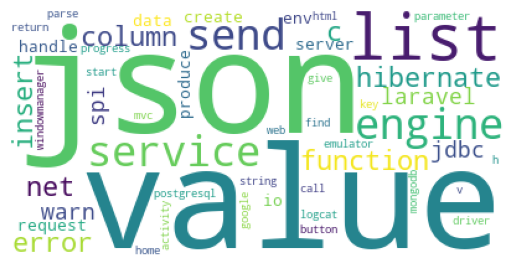

Topic : 2


/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


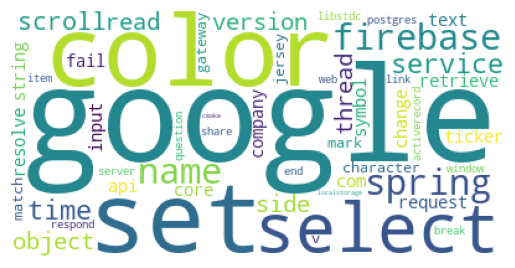

Topic : 3


/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


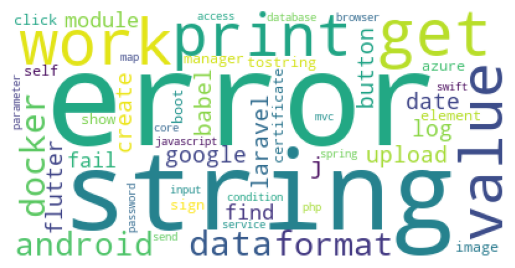

Topic : 4


/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


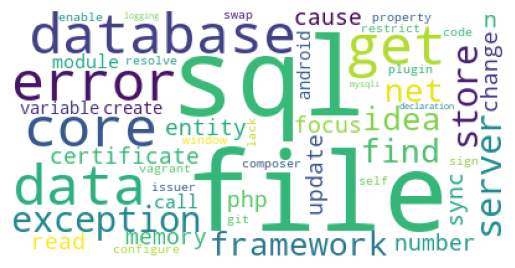

Topic : 5


/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


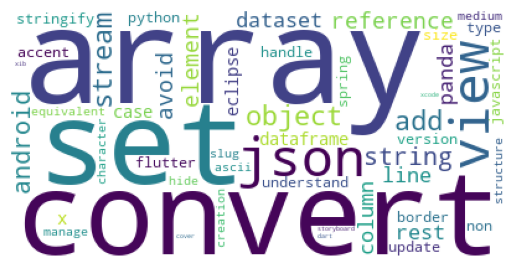

Topic : 6


/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


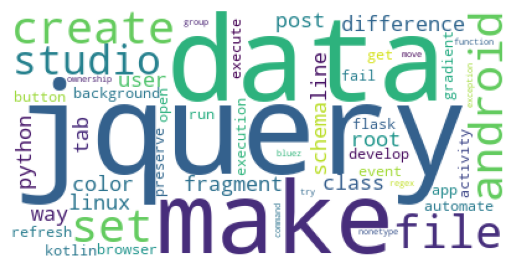

Topic : 7


/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


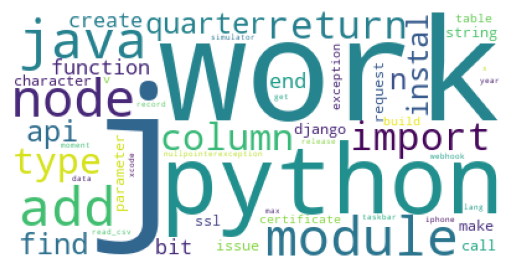

Topic : 8


/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


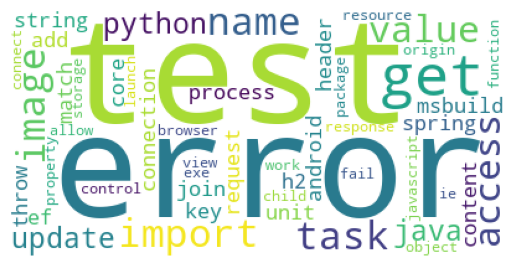

Topic : 9


/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


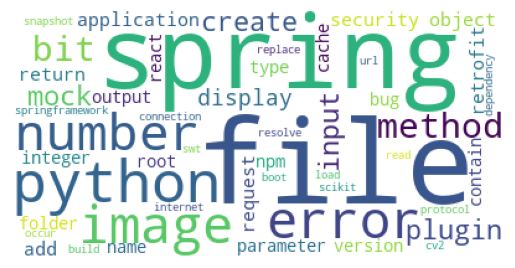

Topic : 10


/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


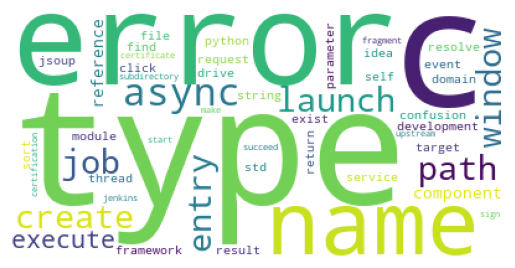

In [16]:
num_top_words = 50

# Extract topic terms
topics_terms = lda_test.print_topics(num_topics=-1, num_words=num_top_words)

# Parse the output to get a list of top words for each topic
top_words_per_topic = []
for topic_terms in topics_terms:
    topic_words = [word.split("*")[1].strip() for word in topic_terms[1].split(" + ")]
    top_words_per_topic.append(topic_words)

# Display or use the extracted top words
for i, top_words in enumerate(top_words_per_topic):
    print(f'Topic : {i + 1}')
    show_cloud(top_words)


### 2.6 Une métrique pour évaluer la séparation / la similarité des topics


In [17]:
# Du point de vue metier, des topics tres proches peuvent etre consideres
# comme etant un seul topic. Il est + interessant d'avoir des topics bien differents les uns des autres.

# Thought about using clustering scores like silhouette, davies-bouldin, etc...
# but lda is different from clustering, it returns not 1 label, but a distribution of probabilities over topics.
# so it's not possible to use davies-bouldin or silhouette directly to check if the topics are well separated.
# Instead, we can use a metric that evaluates the overlap between topics, such as the Jaccard similarity

topn = 1000

def jaccard_similarity(topic1, topic2):
    set1 = set(topic1)
    set2 = set(topic2)
    return len(set1.intersection(set2)) / len(set1.union(set2))

# Example
topic1 = lda_test.show_topic(0, topn=topn)
topn_tokens_topic1 = [token for token, proba in topic1]

print(topic1)
print(len(topic1))
print(topn_tokens_topic1)

topic2 = lda_test.show_topic(1, topn=topn)
topn_tokens_topic2 = [token for token, proba in topic2]

print(topic2)
print(len(topic2))
print(topn_tokens_topic2)

print('Jaccard Similarity between Topics 0 and 1:', jaccard_similarity(topn_tokens_topic1, topn_tokens_topic2))


# Pour avoir une idée sur l'ensemble des topics
def average_jaccard_similarity(lda_model):
    num_topics = lda_model.num_topics
    total_similarity = 0.0
    pair_count = 0

    # Iterate over all pairs of topics
    for i in range(num_topics):
        for j in range(i + 1, num_topics):
            # Get the word distributions for the two topics
            topic1 = lda_model.show_topic(i, topn=topn)
            topn_tokens_topic1 = [token for token, proba in topic1]
            topic2 = lda_model.show_topic(j, topn=topn)
            topn_tokens_topic2 = [token for token, proba in topic2]

            # Calculate Jaccard similarity and update total_similarity
            similarity = jaccard_similarity(topn_tokens_topic1, topn_tokens_topic2)
            total_similarity += similarity
            pair_count += 1

    # Calculate the average Jaccard similarity
    average_similarity = total_similarity / pair_count
    return average_similarity


# Example
average_jaccard = average_jaccard_similarity(lda_test)
print('Average Jaccard Similarity between Topics:', average_jaccard)


[('json', 0.013269667), ('value', 0.013268079), ('list', 0.013268046), ('engine', 0.0100331595), ('send', 0.010033159), ('hibernate', 0.010033155), ('service', 0.010033155), ('function', 0.010033152), ('c', 0.010033096), ('column', 0.01003148), ('insert', 0.010031374), ('net', 0.008875716), ('error', 0.008535848), ('laravel', 0.006798219), ('jdbc', 0.0067966017), ('warn', 0.0067966017), ('spi', 0.0067966017), ('request', 0.0067966008), ('data', 0.0067966008), ('env', 0.0067965994), ('server', 0.0067965984), ('io', 0.0067965975), ('create', 0.006796596), ('handle', 0.006796595), ('produce', 0.006796595), ('postgresql', 0.0067965947), ('v', 0.0067965947), ('mvc', 0.0067965947), ('find', 0.006796593), ('key', 0.006796593), ('driver', 0.006796593), ('html', 0.006796593), ('web', 0.0067965924), ('return', 0.0067965924), ('string', 0.0067965905), ('call', 0.00679659), ('google', 0.00679659), ('mongodb', 0.006796588), ('parameter', 0.0067965835), ('parse', 0.0067964997), ('h', 0.006794957), (

### 2.7 Predictions


In [18]:
new_doc1 = "I have a python problem. I don't understand the difference between a slice and a copy."
new_doc2 = "I have a javascript problem. I don't understand the difference between a div and a span."
new_doc3 = "I like cookies."

# Preprocessing, identique à celui des autres docs

def preprocess_text(text):
    #Cleaning
    text = BeautifulSoup(text, 'html.parser').get_text()
    text = text.lower().strip()

    # Tokenization
    try:
        tokens = nltk.word_tokenize(text)
        tokenizer = nltk.RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(" ".join(tokens))  # Apply RegexpTokenizer to the entire list

        # Remove punctuation (make sure, RegexpTokenizer should have done it already)
        tokens = [token for token in tokens if token not in string.punctuation]

    except Exception as e:
        print(f"Error in tokenization: {e}")
        return []

    # Lemmatization
    lemmatizer = WordNetLemmatizer()

    # Get part of speech for each token
    pos_tags = nltk.pos_tag(tokens)
    lemmatized_tokens = []

    for token, pos_tag in pos_tags:
        # ! Uncommenting next line may crash the cell
        # print(f"Token: {token}, POS Tag: {pos_tag}")
        if pos_tag.startswith('V'):
            # On garde
            lemmatized_tokens.append(lemmatizer.lemmatize(token, pos='v'))
            # Returns the input word unchanged if it cannot be found in WordNet.
        elif pos_tag.startswith('N'):
            # On garde
            try:
                lemmatized_tokens.append(lemmatizer.lemmatize(token, pos='n'))
            except Exception as e:
                print(f"Error lemmatizing verb {token}: {e}")
        # Sinon on supprime

    # Read forbidden words (stopwords, too frequent, too rare) from the file
    with open('./forbidden_words.txt', 'r') as file:
        forbidden = [line.strip() for line in file]

    filtered_list = [token for token in lemmatized_tokens if token not in forbidden]

    # keep uniques
    seen_tokens = set()
    unique_tokens = []

    for token in filtered_list:
        if token not in seen_tokens:
            seen_tokens.add(token)
            if len(token) > 2:
                unique_tokens.append(token)

    return unique_tokens


def predict_topics(text):
    # Tokenize and preprocess the new document
    new_doc_tokens = preprocess_text(text)  # Use the same preprocess function used during training

    # Convert the new document to a bag-of-words representation using the dictionary
    new_doc_bow = dict_test.doc2bow(new_doc_tokens)

    # Infer topic distribution for the new document
    topic_distribution = lda_test.get_document_topics(new_doc_bow)

    # Print the inferred topic distribution
    print(f"Inferred Topic Distribution for {str(text)}:")
    for topic_id, prob in topic_distribution:
        print(f"Topic {topic_id + 1}: Probability = {prob:.4f}")
    print('\n')

    # déterminer un seuil ?


predict_topics(new_doc1)
predict_topics(new_doc2)
predict_topics(new_doc3)

predict_topics(test_df.loc[0, 'title'])
# tres rapide


Inferred Topic Distribution for I have a python problem. I don't understand the difference between a slice and a copy.:
Topic 1: Probability = 0.0114
Topic 2: Probability = 0.0106
Topic 3: Probability = 0.0137
Topic 4: Probability = 0.2330
Topic 5: Probability = 0.0118
Topic 6: Probability = 0.3561
Topic 7: Probability = 0.0109
Topic 8: Probability = 0.0115
Topic 9: Probability = 0.0111
Topic 10: Probability = 0.3299


Inferred Topic Distribution for I have a javascript problem. I don't understand the difference between a div and a span.:
Topic 1: Probability = 0.0114
Topic 2: Probability = 0.3520
Topic 3: Probability = 0.0137
Topic 4: Probability = 0.0120
Topic 5: Probability = 0.0118
Topic 6: Probability = 0.2326
Topic 7: Probability = 0.0109
Topic 8: Probability = 0.0115
Topic 9: Probability = 0.0111
Topic 10: Probability = 0.3329


Inferred Topic Distribution for I like cookies.:
Topic 1: Probability = 0.0340
Topic 2: Probability = 0.0314
Topic 3: Probability = 0.0406
Topic 4: Prob

### 2.8 Bonus : suggestion de questions "similaires" (pas super au point!)


In [19]:
# En plus de proposer des tags/topics, on pourrait utiliser le module similarité de gensim pour
# proposer des articles similaires

lda_index = similarities.MatrixSimilarity(lda_test[corpus_test], num_features=len(dict_test))

top_n = 5
def get_similar_articles(index, model, article_bow, top_n=top_n, first_m_words=300):
  # model[article_bow] retrieves the topic distribution for the BOW.
  # index[model[article_bow] compares the topic distribution for the BOW against the similarity index previously computed.
  similar_docs = index[model[article_bow]]
  top_n_docs = sorted(enumerate(similar_docs), key=lambda item: -item[1])[1:top_n+1]

  # Return a list of tuples with each tuple: (article id, similarity score, first_m_words of article)
  return top_n_docs


In [20]:
def suggest_similar_questions(article_idx):
    print('QUESTION D\'ORIGINE : ', train_df.iloc[article_idx]['body'], '\n')
    print(corpus_test[article_idx])
    sims1 = get_similar_articles(lda_index, lda_test, corpus_test[article_idx])

    for i, (index, score) in enumerate(sims1):
        print('\n', f'QUESTION SIMILAIRE {i+1}/{top_n}:')
        print(f'Score de similarité : {score}', '\n')
        print(train_df.iloc[index]['body'], score, '\n')


suggest_similar_questions(0)
# ok, mm nombre de tuples ds l'index que de tokens ds title_nltk

# Par contre pas hyper convaincant la similarité des derniers articles


QUESTION D'ORIGINE :  For the ongoing projects and for improving our development process we considered adopting TDD as development philosophy. While researching for best practices and how to "sell" the new approach to my colleagues/ developers I came across BDD and found it even more appropriate to what we would need and somehow to be next iteration of TDD. The problem is that up to now I tried only the tool developed by Dan North, JBehave and I cannot say that I am amazed.
The setup seems to me cumbersome and I couldn't find very appropriate documentation for it. On the other hand I tried also spock the groovy tool and up to now I kind of like it.
Q: are there any proper tools to be used for BDD? 
Q: you would use instead spock and deal with the overhead of introducing another language?
 

[(0, 1), (1, 1), (2, 1), (3, 1)]

 QUESTION SIMILAIRE 1/5:
Score de similarité : 1.0 

I am trying to speed up my script. It basically reads a pcap file with Velodyne's Lidar HDL-32 information and 

In [21]:
suggest_similar_questions(1)

# idem, les scores sont bien trop haut


QUESTION D'ORIGINE :  I have spent quite a few hours pondering the subject of exposing list members. In a similar question to mine, Jon Skeet gave an excellent answer. Please feel free to have a look.
ReadOnlyCollection or IEnumerable for exposing member collections?
I am usually quite paranoid to exposing lists, especially if you are developing an API.
I have always used IEnumerable for exposing lists, as it is quite safe, and it gives that much flexibility. Let me use an example here:
public class Activity
{
    private readonly IList<WorkItem> workItems = new List<WorkItem>();

    public string Name { get; set; }

    public IEnumerable<WorkItem> WorkItems
    {
        get
        {
            return this.workItems;
        }
    }

    public void AddWorkItem(WorkItem workItem)
    {
        this.workItems.Add(workItem);
    }
}

Anyone who codes against an IEnumerable is quite safe here. If I later decide to use an ordered list or something, none of their code breaks and it is 

In [22]:
# test on new, unseen question

test_article = "Capricorn Business Acquisitions Inc. (TSXV: CAK.H) (the “Company“) is pleased to announce that its board has approved the issuance of 70,000 stock options (“Stock Options“) to directors on April 19, 2020."

def suggest_similar_to_unseen(text):
    print('TEXTE D\'ORIGINE : ' + text, '\n')

    article_tokens = preprocess_text(text)
    article_bow = dict_test.doc2bow(article_tokens)
    sims1 = get_similar_articles(lda_index, lda_test, article_bow)

    for i, (index, score) in enumerate(sims1):
        print('\n', f'QUESTION SIMILAIRE {i+1}/{top_n}:')
        print(f'Score de similarité : {score}', '\n')
        print(train_df.iloc[index]['body'], score, '\n')


suggest_similar_to_unseen(test_article)

# Vraiment pas terrible pour l'instant.
# Il faudra tester avec les embedding statiques et contextualisés


TEXTE D'ORIGINE : Capricorn Business Acquisitions Inc. (TSXV: CAK.H) (the “Company“) is pleased to announce that its board has approved the issuance of 70,000 stock options (“Stock Options“) to directors on April 19, 2020. 


 QUESTION SIMILAIRE 1/5:
Score de similarité : 1.0 

I know I can create an NSArray with @[@"foo", @"bar"] or an NSDictionary with @{@0 : @"foo", @1 : @"bar"}.
Is there a literal syntax for creating an NSMutableArray or an NSMutableDictionary?
 1.0 


 QUESTION SIMILAIRE 2/5:
Score de similarité : 0.9996796250343323 

I have a PL/SQL procedure that does a lot of SUBSTRs on a VARCHAR2 parameter. I would like to remove the length limit, so I tried to change it to CLOB.
Works fine, but performance suffers, so I did some tests (based on these tests from 2005).

UPDATE: I can reproduce this on several different instances with different Oracle versions and different hardware, dbms_lob.substr is always noticeable slower than substr(CLOB), and a lot slower than SUBSTR(VAR

### 2.9 Test lda on other datasets


In [23]:
lda_test, corpus_test, dict_test = suggest_topics_using_LDA(train_df, 'title_spacy')


Average topic coherence: -18.1219.
u_mass Coherence Score: -19.2451.
c_v Coherence Score: 0.6277.
c_npmi Coherence Score: -0.4711.
Perplexity: -7.3201.


[([(0.037765887, 'file'),
   (0.027132174, 'error'),
   (0.027129479, 'create'),
   (0.02165878, 'read'),
   (0.016492028, 'result'),
   (0.016483013, 'write'),
   (0.011178284, 'image'),
   (0.011171969, 'test'),
   (0.011171968, 'react'),
   (0.011171967, 'case')],
  -14.805118116351807),
 ([(0.05334453, 'use'),
   (0.026905788, 'column'),
   (0.026901409, 'find'),
   (0.018083472, 'return'),
   (0.01796376, 'array'),
   (0.013674512, 'browser'),
   (0.013674511, 'error'),
   (0.013674507, 'add'),
   (0.0130076995, 'sync'),
   (0.00996058, 'work')],
  -16.61829666684885),
 ([(0.038655907, 'update'),
   (0.024401784, 'object'),
   (0.01961902, 'line'),
   (0.019616619, 'string'),
   (0.014833849, 'json'),
   (0.014831407, 'struct'),
   (0.010048678, 'handle'),
   (0.010048678, 'bit'),
   (0.0100486735, 'web'),
   (0.010048673, 'file')],
  -16.83064457553226),
 ([(0.026295144, 'set'),
   (0.021961521, 'rest'),
   (0.017678076, 'color'),
   (0.01767592, 'spring'),
   (0.013366324, 'refe

In [24]:
lda_test, corpus_test, dict_test = suggest_topics_using_LDA(train_df, 'body_nltk')

# Score un peu meilleur
# (sauf perplexité, similaire)
# mais les topics sont bien mieux différentiés !


Average topic coherence: -3.4200.
u_mass Coherence Score: -3.8066.
c_v Coherence Score: 0.3931.
c_npmi Coherence Score: -0.0909.
Perplexity: -6.7980.


[([(0.02188533, 'test'),
   (0.014728438, 'class'),
   (0.0122654755, 'try'),
   (0.010507769, 'data'),
   (0.009635018, 'return'),
   (0.009057248, 'code'),
   (0.008895966, 'page'),
   (0.00820649, 'get'),
   (0.0076792245, 'string'),
   (0.007650908, 'value')],
  -1.3057826915151507),
 ([(0.01715076, 'input'),
   (0.013281505, 'value'),
   (0.012769691, 'name'),
   (0.010965839, 'type'),
   (0.010311481, 'get'),
   (0.009991227, 'string'),
   (0.009460607, 'error'),
   (0.008610679, 'class'),
   (0.008408873, 'json'),
   (0.008079728, 'file')],
  -1.364055696236591),
 ([(0.018164314, 'function'),
   (0.01562118, 'object'),
   (0.011868134, 'value'),
   (0.010163936, 'parameter'),
   (0.010015481, 'javascript'),
   (0.009591886, 'work'),
   (0.008966573, 'script'),
   (0.008946235, 'make'),
   (0.008664116, 'string'),
   (0.008598979, 'get')],
  -1.5739129311115698),
 ([(0.018512102, 'spring'),
   (0.016200926, 'file'),
   (0.015965512, 'boot'),
   (0.015032089, 'java'),
   (0.013222

In [25]:
average_jaccard = average_jaccard_similarity(lda_test)
print('Average Jaccard Similarity between Topics:', average_jaccard)

# OK


Average Jaccard Similarity between Topics: 0.3148620259796235


In [26]:
lda_test, corpus_test, dict_test = suggest_topics_using_LDA(train_df, 'body_spacy')

average_jaccard = average_jaccard_similarity(lda_test)
print('Average Jaccard Similarity between Topics:', average_jaccard)

# Un peu moins bien / nltk


Average topic coherence: -2.7364.
u_mass Coherence Score: -3.9309.
c_v Coherence Score: 0.3800.
c_npmi Coherence Score: -0.1231.
Perplexity: -6.7549.


[([(0.04234771, 'import'),
   (0.022228261, 'error'),
   (0.019236099, 'file'),
   (0.01790624, 'line'),
   (0.016450558, 'module'),
   (0.012744961, 'test'),
   (0.012719301, 'try'),
   (0.012651218, 'want'),
   (0.011249081, 'react'),
   (0.010935592, 'code')],
  -1.4833329590692084),
 ([(0.014094035, 'type'),
   (0.011998254, 'value'),
   (0.011188882, 'object'),
   (0.01114472, 'return'),
   (0.0109659955, 'try'),
   (0.01067799, 'error'),
   (0.009210584, 'result'),
   (0.00909341, 'class'),
   (0.008659646, 'const'),
   (0.00813123, 'work')],
  -1.601060518528806),
 ([(0.020551058, 'fine'),
   (0.02011247, 'security'),
   (0.02001958, 'web'),
   (0.01584756, 'function'),
   (0.012997525, 'create'),
   (0.012121321, 'class'),
   (0.010620847, 'method'),
   (0.009323299, 'want'),
   (0.009171983, 'user'),
   (0.008565859, 'use')],
  -1.7340810737815457),
 ([(0.03729427, 'android'),
   (0.0154740475, 'use'),
   (0.014672537, 'way'),
   (0.014501287, 'work'),
   (0.013950993, 'try'),

### 2.10 LDA Multicore


In [27]:
# add grid search cv

def suggest_topics_using_LDA(df, feature, num_topics):
    documents = df[feature].tolist()
    gensim_dictionary = Dictionary(documents)
    corpus = [gensim_dictionary.doc2bow(doc) for doc in documents]

    # Set training parameters.
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.

    # Make a index to word dictionary.
    temp = gensim_dictionary[0]  # This is only to "load" the dictionary.
    id2word = gensim_dictionary.id2token

    # Create model, fit it on corpus
    model = LdaMulticore(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every, random_state=42)

    # Compute Coherence Score (Umass)
    coherence_umass = CoherenceModel(model=model, texts=documents, dictionary=gensim_dictionary, coherence='u_mass')
    coherence_lda_umass = coherence_umass.get_coherence()
    print('u_mass Coherence Score: %.4f.' % coherence_lda_umass)

    # Compute Coherence Score (cv)
    coherence_cv = CoherenceModel(model=model, texts=documents, dictionary=gensim_dictionary, coherence='c_v')
    coherence_lda_cv = coherence_cv.get_coherence()
    print('c_v Coherence Score: %.4f.' % coherence_lda_cv)

    # Compute Coherence Score (npmi)
    coherence_npmi = CoherenceModel(model=model, texts=documents, dictionary=gensim_dictionary, coherence='c_npmi')
    coherence_lda_npmi = coherence_npmi.get_coherence()
    print('c_npmi Coherence Score: %.4f.' % coherence_lda_npmi)


    # similarité des topics obtenus
    average_jaccard = average_jaccard_similarity(model)
    print('Average Jaccard Similarity between Topics:', average_jaccard)

    # Visualize the topics
    vis_data = gensimvis.prepare(model, corpus, gensim_dictionary)
    display(pyLDAvis.display(vis_data))

    # Uncomment the next line if you want to save the plot to a file
    # pyLDAvis.save_html(vis_data, 'lda_vis.html')

    # scores
    scores = [coherence_lda_umass, coherence_lda_cv, coherence_lda_npmi, average_jaccard]

    return model, corpus, gensim_dictionary, scores


lda_ref, corpus_ref, dict_ref, scores_test = suggest_topics_using_LDA(train_df, 'body_nltk', 9)
# On gagne + d'1 min


### 2.11 Hyperparameter tuning : num_topics


In [28]:
# Choix du nb de topics k
# Contrainte métier : k pas trop élevé, car difficile de comprendre/nommer les topics

umass_results = []
cv_results = []
npmi_results = []
jacc_results = []

k_max = 15 # modifier pour tester davantage

for i in range(3, k_max, 2):
    print(f'nb de topics : {i}')
    lda_test, corpus_test, dict_test, scores_test = suggest_topics_using_LDA(quick_df, 'title_nltk', i)
    umass_results.append(scores_test[0])
    cv_results.append(scores_test[1])
    npmi_results.append(scores_test[2])
    jacc_results.append(scores_test[3])


nb de topics : 3


u_mass Coherence Score: -17.3237.
c_v Coherence Score: 0.5610.
c_npmi Coherence Score: -0.4218.
Average Jaccard Similarity between Topics: 1.0


nb de topics : 5
u_mass Coherence Score: -18.5032.
c_v Coherence Score: 0.6223.
c_npmi Coherence Score: -0.4708.
Average Jaccard Similarity between Topics: 1.0


nb de topics : 7
u_mass Coherence Score: -18.3734.
c_v Coherence Score: 0.6116.
c_npmi Coherence Score: -0.4603.
Average Jaccard Similarity between Topics: 1.0


nb de topics : 9
u_mass Coherence Score: -18.9520.
c_v Coherence Score: 0.6329.
c_npmi Coherence Score: -0.4805.
Average Jaccard Similarity between Topics: 1.0


nb de topics : 11
u_mass Coherence Score: -19.1639.
c_v Coherence Score: 0.6336.
c_npmi Coherence Score: -0.4852.
Average Jaccard Similarity between Topics: 1.0


nb de topics : 13
u_mass Coherence Score: -18.9170.
c_v Coherence Score: 0.6223.
c_npmi Coherence Score: -0.4727.
Average Jaccard Similarity between Topics: 1.0


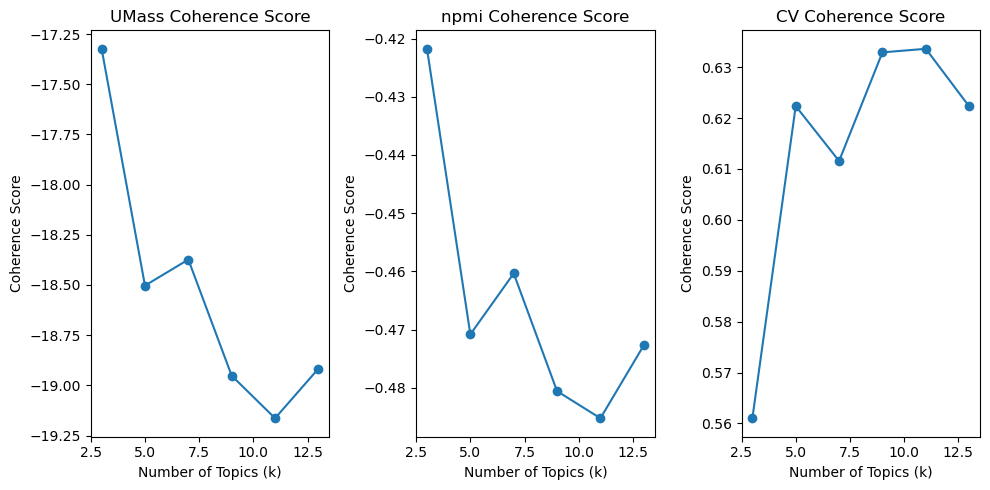

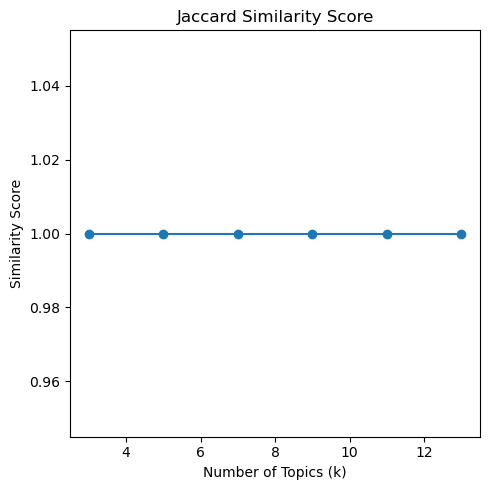

In [29]:
# Plotting UMass Coherence Score
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.plot(range(3, k_max, 2), umass_results, marker='o')
plt.title('UMass Coherence Score')
plt.xlabel('Number of Topics (k)')
plt.ylabel('Coherence Score')

# Plotting npmi Coherence Score
plt.subplot(1, 3, 2)
plt.plot(range(3, k_max, 2), npmi_results, marker='o')
plt.title('npmi Coherence Score')
plt.xlabel('Number of Topics (k)')
plt.ylabel('Coherence Score')

# Plotting CV Coherence Score
plt.subplot(1, 3, 3)
plt.plot(range(3, k_max, 2), cv_results, marker='o')
plt.title('CV Coherence Score')
plt.xlabel('Number of Topics (k)')
plt.ylabel('Coherence Score')

plt.tight_layout()
plt.show()

# Plotting Jaccard Similarity Score
plt.figure(figsize=(5, 5))
plt.plot(range(3, k_max, 2), jacc_results, marker='o')
plt.title('Jaccard Similarity Score')
plt.xlabel('Number of Topics (k)')
plt.ylabel('Similarity Score')

plt.tight_layout()
plt.show()


In [30]:
# problem : augmenter le nb de topics revient à overfitter le modele,
# ce qui penalise umass et npmi et favorise c_v (on le voit bien sur les 3 premieres courbes, en haut)
# En revanche les resultats pour la similarté (en bas) sont plus faciles à interpréter.

# Ici entre la méthode du coude sur umass (k=7), npmi (k=7) et cv (k=7)
# + minimum jaccard (k=9),
# je prendrais k=7 ou k=9 comme nombre opti de topics, selon qu'on préfère + ou - précis

# c un nombre raisonnable, qui nous donne les topics les mieux différenciés
# (d'après Jaccard)
# et les + cohérents (autres scores)


## 3 tfidf + NMF


### 3.1 Topics


In [31]:
quick_df = data[::1]

train_df, test_df = train_test_split(quick_df, test_size=0.1, random_state=42)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print(train_df.shape)
print(test_df.shape)


(42898, 8)
(4767, 8)


In [57]:
def suggest_topics_using_TFIDF_NMF(df, feature, num_topics=9, alea=42, query='exemple'):
    documents = df[feature].tolist()

    # TF-IDF Vectorization
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

    # NMF
    nmf = NMF(n_components=num_topics, random_state=alea)
    nmf.fit(tfidf_matrix)

    # Access basis matrix (W)
    basis_matrix_W = nmf.transform(tfidf_matrix) # = documents-topics

    # Access coefficients matrix (H)
    coefficients_matrix_H = nmf.components_ # = topics-mots

    # Number of top words to display for each topic
    n_top_words = 10

    coherence_values = []

    # Create Gensim dictionary
    gensim_dictionary = Dictionary.from_documents([tfidf_vectorizer.get_feature_names_out()])

    # Print top words for each topic
    for topic_idx, topic in enumerate(coefficients_matrix_H):
        top_words_idx = topic.argsort()[:-n_top_words - 1 :-1]
        top_words = [tfidf_vectorizer.get_feature_names_out()[i] for i in top_words_idx]
        print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

    return nmf, tfidf_vectorizer, tfidf_matrix, basis_matrix_W, coefficients_matrix_H


# Example usage:
nmf_test, vectorizer_test, X_original, W_docs_topics, H_topics_words = suggest_topics_using_TFIDF_NMF(train_df, 'title')

# bcp + rapide que la lda a entrainer
# (logique)


Topic #1: using, javascript, js, jquery, image, java, react, selenium, server, files
Topic #2: android, studio, app, ios, visual, change, gradle, image, add, project
Topic #3: net, asp, core, mvc, web, api, json, framework, application, authentication
Topic #4: file, directory, text, read, upload, load, csv, download, line, open
Topic #5: string, array, convert, object, json, pandas, value, java, dataframe, column
Topic #6: spring, boot, data, jpa, application, security, rest, json, hibernate, request
Topic #7: use, js, react, function, class, async, vs, node, instead, angular
Topic #8: error, failed, module, does, type, js, code, getting, react, app
Topic #9: python, install, selenium, module, script, windows, list, image, opencv, pandas


In [33]:
test_list = [0, 1, 2, 3, 4, 5]

result = test_list[:-3 -1 :-1]
result

# i see


[5, 4, 3]

### 3.2 Prediction


In [34]:
# prediction

query = 'exemple of a python javascript problem'
query_vect = vectorizer_test.transform([query])
query_topics = nmf_test.transform(query_vect)
print(query_topics)
print(type(query_topics), '\n')

# Interpret the resulting topic distribution
top_topics_idx = query_topics[0].argsort()[::-1]  # Sort in descending order
top_topics_strength = query_topics[0, top_topics_idx]

# Print or use the top topics and their strengths
for topic_idx, strength in zip(top_topics_idx, top_topics_strength):
    print(f"Topic #{topic_idx + 1}: Strength {strength:.4f}")


[[0.00452875 0.         0.         0.         0.00605451 0.
  0.12417663 0.         0.         0.0020023 ]]
<class 'numpy.ndarray'> 

Topic #7: Strength 0.1242
Topic #5: Strength 0.0061
Topic #1: Strength 0.0045
Topic #10: Strength 0.0020
Topic #9: Strength 0.0000
Topic #8: Strength 0.0000
Topic #6: Strength 0.0000
Topic #4: Strength 0.0000
Topic #3: Strength 0.0000
Topic #2: Strength 0.0000


In [35]:
pprint(H_topics_words)


array([[1.72252131e-02, 1.34681502e-03, 2.12085742e-03, ...,
        0.00000000e+00, 0.00000000e+00, 2.88851664e-03],
       [0.00000000e+00, 0.00000000e+00, 2.74801493e-05, ...,
        0.00000000e+00, 1.68518007e-02, 0.00000000e+00],
       [0.00000000e+00, 9.17482868e-05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.18594352e-03, 0.00000000e+00, ...,
        1.46778706e-02, 0.00000000e+00, 0.00000000e+00],
       [1.27108243e-03, 3.42728307e-05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])


In [36]:
print(X_original.shape)


(42898, 9278)


### 3.3 Erreur de reconstruction


In [45]:
# i have an idea. could we partially evaluate the performance of a nmf model by checking how close it gets to
# recreating the original matrix ? we could calculate a distance between the original matrix
# and the matricial product of basis_matrix_W by coefficients_matrix_H
# we can do a similar comparison for lda
# ca peut nous donner une idee de nb de topics trop petits, et aider a comparer lda et nmf
# pour un mm nb de topics

# ... a few minutes later...

# Ok apparemment ca existe deja mon truc. ca s'appelle l'erreur de reconstruction.

# Convert the sparse matrix to a dense array
X_original_dense = X_original.toarray()

# Reconstruct the matrix
X_rebuilt = np.dot(W_docs_topics, H_topics_words)
# X_rebuilt_dense = X_rebuilt.toarray()

# Calculate Frobenius norm of the original matrix
print(f"frobenius_norm_original = {np.linalg.norm(X_original_dense, ord='fro')}")


frobenius_norm_original = 207.10142442774264


In [44]:
# Calculate the reconstruction error
print(f"error = {np.linalg.norm(X_original_dense - X_rebuilt)}")

# On est très proche


error = 203.39438835356367


In [46]:
# lda
# bcp plus compliqué à calculer.

# En plus les dimensions des matrices originales ne sont pas exactement les mêmes
# (on a utilisé un bag of words pour la LDA, et td-idf pour la NMF)

# Jaccard reste le meilleur outil de comparaison ici


u_mass Coherence Score: -1.6516.
c_v Coherence Score: 0.5778.
c_npmi Coherence Score: 0.0477.
Average Jaccard Similarity between Topics: 0.20579285413777954


### 3.4 Jaccard similarity


In [58]:
def get_top_tokens_for_topic(nmf_model, topic_idx, topn=10):
    # Get the top tokens for a given topic index
    topic_tokens = nmf_model.components_[topic_idx]
    top_tokens_idx = topic_tokens.argsort()[-topn:][::-1]
    return top_tokens_idx


def average_jaccard_similarity_nmf(nmf_model, topn=10):
    num_topics = nmf_model.components_.shape[0]
    total_similarity = 0.0
    pair_count = 0

    # Iterate over all pairs of topics
    for i in range(num_topics):
        for j in range(i + 1, num_topics):
            # Get the top tokens for the two topics
            topic1 = get_top_tokens_for_topic(nmf_model, i, topn)
            topic2 = get_top_tokens_for_topic(nmf_model, j, topn)

            # Calculate Jaccard similarity and update total_similarity
            similarity = jaccard_similarity(topic1, topic2)
            total_similarity += similarity
            pair_count += 1

    # Calculate the average Jaccard similarity
    average_similarity = total_similarity / pair_count
    return average_similarity


# Example usage
average_jaccard = average_jaccard_similarity_nmf(nmf_test)
print('Average Jaccard Similarity between Topics:', average_jaccard)

# 5x moins bien que la LDA


Average Jaccard Similarity between Topics: 0.027128005198180632


## 4 Autres pistes possibles


### embedding + K-Means (ou autre algo de clusterisation)


In [40]:
# Pb : le kmeans va definir des topics entierement disjoints,
# chaque document appartiendra" à un cluster/topic.
# c'est interessant, mais pas exactement ce qu'on cherche a faire ds ce projet
# (nous voulons predire plusieurs tags, pas seulement 1).

# Meme remarque avec les autres algorithmes de clustering, qui assignent un label unique
# a chaque doc (hierarchique, dbscan, etc...)

# en plus, on doit tjs attribuer manuellement un nom a chaque topic (cluster) defini par le kmeans.


### doc2vec


In [41]:
# sera testé avec les modeles supervisés


### embedding + reduction dim (pca, t-sne, manifold, ...) ou modele generatif


In [42]:
# peut fonctionner, mais on passe aux supervises on a dit !


## Conclusion approche non supervisée


In [43]:
# On n'a pas a ma connaissance d'outil "tout pret" pour la visualisation des topics definis par la nmf,
# comme pyLDAvis pour la lda.
# Pire, on n'a pas non plus d'outils pour calculer rapidement la coherence des topics obtenus
# on pourrait definir des scores customs pour la nmf en s'inspirant de la classe CoherenceModel()
# de gensim, mais
# comme les modeles purement non-supervises requierent une etape manuelle d'interpretation/nommage des topics,
# il est temps de s'interesser aux modeles supervises qui eux vont nous retourner directement
# les tags, sans necessiter d'intervention.
# Ils seront donc plus interessants a deployer pour ce projet.

# approche semi-supervisee ?
# On pourrait par exemple comparer la distribution des n topics calculée par la lda ou la nmf,
# à la distribution des n tags les plus présents.
# Ca pourrait nous aider a nommer certains des tags, mais ca ne fonctionnera jamais pour toute la liste.
# Je ne vois pas comment completement éliminer le besoin d'une intervention humaine a cette etape,
# si on travaille uniaue,ent avec les modeles non-supervises.
